# Model Testing

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_roc_curve, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, normalize
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# saving scaler
# import pickle

# extreme gradient boosting
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree

# eli5 for feature importances
# import eli5
# from eli5.sklearn import PermutationImportance

# from sklearn.cluster import KMeans
# from scipy.cluster.vq import kmeans2

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
# from tqdm import tqdm

# Advanced plotting functionality with seaborn
# import seaborn as sns
import warnings


# sns.set(style="whitegrid")  # can set style depending on how you'd like it to look

C:\Users\sathya\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## testing

In [2]:
df = pd.read_csv('../leap-data/training-data.csv')
df = df.drop(columns=['id', df.columns[-1]])
df.columns = [col.strip() for col in df.columns]
orig = df.copy()
# unfortunately, due to a difference in the python/mac Leap SDK and the orion v4 unity api,
# these parameters require large changes to the user's experience to obtain.
df = df.drop(columns=['s', 'tx', 'ty', 'tz', 'r11', 'r12', 'r13', 'r21', 'r22', 'r23', 'r31', 'r32', 'r33'])

In [3]:
df.head()

,label,hand_dir_1,hand_dir_2,hand_dir_3,thumb_dir_1,thumb_dir_2,thumb_dir_3,thumb_meta_center_1,thumb_meta_center_2,thumb_meta_center_3,...,pinkie_int_dir_3,pinkie_dist_center_1,pinkie_dist_center_2,pinkie_dist_center_3,pinkie_dist_dir_1,pinkie_dist_dir_2,pinkie_dist_dir_3,pinkie_tip_pos_1,pinkie_tip_pos_2,pinkie_tip_pos_3
0,a,-0.120760,0.579282,-0.806132,-0.214847,0.210968,-0.953590,0.746992,106.059,86.7526,...,-0.042461,24.5667,108.259,18.69510,0.853832,-0.518814,-0.042461,29.2316,98.872,25.75520
1,a,-0.048483,0.581064,-0.812412,-0.246875,0.211798,-0.945619,-2.682590,111.124,76.2048,...,0.093596,26.5309,112.363,-1.41106,0.815760,-0.570767,0.093596,26.4443,109.361,-6.36915
2,a,-0.024012,0.493538,-0.869393,-0.144569,0.215404,-0.965765,-14.762700,112.036,64.1876,...,-0.051356,20.9811,110.391,-12.51030,0.898600,-0.435752,-0.051356,17.3276,100.707,-4.96892
3,a,0.040212,0.444643,-0.894805,-0.274663,0.148225,-0.950047,36.733700,131.752,82.8569,...,0.050731,72.6394,121.462,4.39365,0.852042,-0.521009,0.050731,66.6906,114.068,-8.40204
4,a,0.058143,0.488072,-0.870865,-0.124370,0.068235,-0.989887,45.695500,113.693,80.5041,...,0.247188,90.3739,116.587,11.62320,0.819272,-0.517389,0.247188,83.8689,113.521,23.75930


In [4]:
# find columns that we have to transform
full_names_vec = list(set([val[:-2] for val in df.columns.values \
                        if 'center' in val or 'pos' in val or 'dir' in val]))
full_names_pos = list(set([val[:-2] for val in df.columns.values \
                        if 'center' in val or 'pos' in val]))

In [5]:
# naive test
X = df[df.columns[1:]]
# 
def un_rotate():
    for index, row in tqdm(X.iterrows()):
        Rinv = np.linalg.inv(np.array([
            [row['r11'], row['r12'], row['r13']],
            [row['r21'], row['r22'], row['r23']],
            [row['r31'], row['r32'], row['r33']],
        ]))
        t0 = np.array([row['tx'], row['ty'], row['tz']])
        for vec in full_names_vec:
            coord = np.array([row[vec+'_1'], row[vec+'_2'], row[vec+'_3']])
            if 'center' in vec or 'pos' in vec:
                coord -= t0
                coord /= row['s']
                coord = Rinv @ coord
            else: 
                coord = Rinv @ coord
                coord /= np.linalg.norm(coord)
            row[vec+'_1'], row[vec+'_2'], row[vec+'_3'] = coord

def recenter():
    for index, row in (X.iterrows()):
        for vec in full_names_pos:
            coord = np.array([row[vec+'_1'], row[vec+'_2'], row[vec+'_3']])
            coord /= np.linalg.norm(coord)
            row[vec+'_1'], row[vec+'_2'], row[vec+'_3'] = coord
#         print(row)
            
# recenter()
    
# un_rotate()

y = df['label']
def replace_letter_with_number(c):
    return ord(c.strip()) - ord('a')
y = y.apply(replace_letter_with_number)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# 0.25 x 0.666 = 0.167
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

In [7]:
X_train

,hand_dir_1,hand_dir_2,hand_dir_3,thumb_dir_1,thumb_dir_2,thumb_dir_3,thumb_meta_center_1,thumb_meta_center_2,thumb_meta_center_3,thumb_meta_dir_1,...,pinkie_int_dir_3,pinkie_dist_center_1,pinkie_dist_center_2,pinkie_dist_center_3,pinkie_dist_dir_1,pinkie_dist_dir_2,pinkie_dist_dir_3,pinkie_tip_pos_1,pinkie_tip_pos_2,pinkie_tip_pos_3
1281,-0.242073,0.468959,-0.849399,0.120624,0.031896,-0.992186,7.58355,90.8559,87.7181,0.368835,...,-0.201706,29.4557,108.3940,-15.37280,0.927940,-0.313437,-0.201706,26.02870,77.9721,10.97480
2039,0.001559,0.309672,-0.950842,0.042073,0.202056,-0.978470,6.26149,116.0410,33.3183,0.982434,...,0.256086,29.0119,67.9053,24.26530,0.851060,-0.458385,0.256086,19.81100,55.0135,15.32720
1155,0.075498,0.376030,-0.923527,-0.233921,0.244011,-0.941137,-27.06180,68.5398,103.3100,0.200594,...,0.223331,21.3520,67.1814,52.00240,0.948354,-0.225272,0.223331,18.73850,61.8453,63.57720
1315,0.259330,0.819072,-0.511730,0.226366,0.318135,-0.920624,-43.20420,80.8462,78.9151,0.506063,...,0.003270,10.2938,104.9470,9.69670,0.684681,-0.728835,0.003270,3.44459,93.9573,1.47277
594,-0.046185,0.506758,-0.860850,-0.107352,0.027072,-0.993852,-23.88310,126.9090,68.2696,0.976911,...,-0.282774,-48.4392,80.0079,42.22460,0.955307,0.086178,-0.282774,-46.07240,73.4421,50.51670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,0.271558,0.538144,-0.797908,0.604341,-0.134530,-0.785286,69.13020,140.6350,34.7184,0.801126,...,0.258989,40.2352,102.1900,6.17172,0.893931,-0.365802,0.258989,34.80930,96.7292,16.99390
2382,0.309665,0.462750,-0.830644,-0.029434,-0.735338,-0.677061,11.15470,144.5370,24.4276,0.989014,...,0.241687,42.3173,89.2807,37.19010,0.795442,-0.555751,0.241687,32.93600,82.6188,46.91190
2005,-0.359461,0.735337,-0.574515,0.036978,-0.798712,-0.600576,-10.61070,174.6580,76.1821,0.854250,...,-0.425962,33.6525,139.0920,47.42070,0.888377,-0.171298,-0.425962,35.11280,122.5760,49.00520
435,-0.004825,0.462780,-0.886460,0.124819,-0.181339,-0.975467,76.84300,136.6890,112.2710,0.440727,...,0.187721,117.2270,136.5610,30.80250,0.844185,-0.502108,0.187721,104.00500,130.0430,31.99510


In [8]:
def naive_scale():
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)

    with open('./scaler.pkl','wb') as f:
        pickle.dump(scaler, f)

#naive_scale()

C:\Users\sathya\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\sathya\miniconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-mlogloss:1.93209	validation_1-mlogloss:2.12880
[1]	validation_0-mlogloss:1.39709	validation_1-mlogloss:1.66628
[2]	validation_0-mlogloss:1.07744	validation_1-mlogloss:1.38314
[3]	validation_0-mlogloss:0.86003	validation_1-mlogloss:1.17896
[4]	validation_0-mlogloss:0.70175	validation_1-mlogloss:1.03504
[5]	validation_0-mlogloss:0.58342	validation_1-mlogloss:0.92475
[6]	validation_0-mlogloss:0.49215	validation_1-mlogloss:0.83673
[7]	validation_0-mlogloss:0.42080	validation_1-mlogloss:0.76620
[8]	validation_0-mlogloss:0.36428	validation_1-mlogloss:0.70970
[9]	validation_0-mlogloss:0.31897	validation_1-mlogloss:0.66504
[10]	validation_0-mlogloss:0.28275	validation_1-mlogloss:0.62795
[11]	validation_0-mlogloss:0.25320	validation_1-mlogloss:0.59649
[12]	validation_0-mlogloss:0.22938	validation_1-mlogloss:0.57149
[13]	validation_0-mlogloss:0.20961	validation_1-mlogloss:0.55089
[14]	validation_0-mlogloss:0.19352	validation_1-mlogloss:0.53478
[15]	validation_0-mlogloss:0.18005	

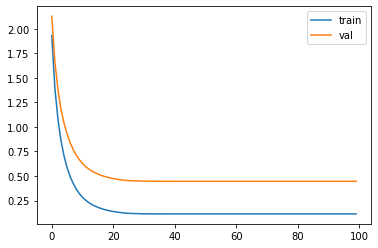

In [9]:
model = xgb.XGBClassifier(reg_alpha = 3, reg_lambda=4)
evalset = [(X_train, y_train), (X_val,y_val)]
model.fit(X_train, y_train, eval_metric='mlogloss', eval_set=evalset)

# model training results
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='val')
plt.legend()

In [10]:
y_pred = model.predict(X_test)

# confusion mat
mat = confusion_matrix(y_test, y_pred)

# classification report
print(classification_report(y_test, y_pred))

# raw accuracy 
score = accuracy_score(y_test, y_pred)
print("Accuracy score is", score)

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       0.94      1.00      0.97        32
           2       0.97      0.91      0.94        34
           3       0.90      0.70      0.79        27
           4       0.88      0.80      0.84        35
           5       0.97      0.97      0.97        37
           6       0.94      0.84      0.89        38
           7       0.92      1.00      0.96        33
           8       0.97      0.97      0.97        31
           9       0.98      0.98      0.98        45
          10       0.93      0.96      0.95        28
          11       1.00      0.97      0.98        33
          12       0.80      0.83      0.81        29
          13       0.74      0.76      0.75        38
          14       0.93      1.00      0.97        28
          15       0.97      0.89      0.93        38
          16       1.00      0.95      0.97        38
          17       0.97    

In [11]:
roc_auc_score(y_test.values, model.predict_proba(X_test.values), multi_class='ovr')

0.996110909008972

In [12]:
# feature importances
sorted(list(zip(X.columns, model.feature_importances_)), key=lambda x: -x[1], )

[('index_prox_dir_3', 0.050706267),
 ('pinkie_meta_center_3', 0.04564503),
 ('thumb_meta_dir_2', 0.042521115),
 ('index_prox_dir_2', 0.04082143),
 ('middle_meta_center_3', 0.03325426),
 ('ring_dir_1', 0.029347925),
 ('pinkie_meta_dir_3', 0.028541753),
 ('thumb_meta_dir_3', 0.027919924),
 ('thumb_int_center_1', 0.024619099),
 ('middle_prox_center_3', 0.023935542),
 ('pinkie_dir_3', 0.023691833),
 ('index_meta_dir_1', 0.020893848),
 ('ring_dir_3', 0.019884719),
 ('index_meta_center_3', 0.019560562),
 ('index_int_center_3', 0.019492282),
 ('ring_int_center_3', 0.018459218),
 ('ring_meta_center_3', 0.017707746),
 ('middle_prox_dir_3', 0.01654682),
 ('pinkie_meta_dir_1', 0.016257426),
 ('thumb_dir_3', 0.016014002),
 ('index_dir_2', 0.014742906),
 ('middle_int_center_3', 0.014263501),
 ('index_meta_dir_3', 0.014191946),
 ('index_meta_dir_2', 0.014185236),
 ('thumb_meta_center_2', 0.01408177),
 ('ring_meta_dir_2', 0.013584199),
 ('index_dir_1', 0.01339085),
 ('ring_prox_dir_2', 0.012276589),


ImportError: You must install graphviz to plot tree

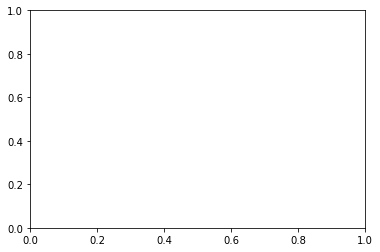

In [22]:
plot_tree(model, filled=True, num_trees=4)
plt.savefig('xgboost_tree.png', dpi=330, bbox_inches='tight')

In [ ]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(range(5)), yticklabels=list(range(5)))
plt.xlabel('true label')
plt.ylabel('predicted label')

In [13]:
model.save_model('alphabet-simplified.json')